## XCEPTION NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.12.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 2000 images belonging to 5 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2000 images belonging to 5 classes.


In [5]:
def xception(input_shape, n_classes):
  
  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 128, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 256, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])
    
    return x
  
  
  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])
    
    return tensor
  
  
  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 1024, 1, 2)
    
    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)
  
    return x
  
  
  input = Input(input_shape)
  
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 5

K.clear_session()
model = xception(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 re_lu_6 (ReLU)                 (None, 28, 28, 728)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 728)  536536     ['re_lu_6[0][0]']                
 onv2D)                                                                                           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 728)  186368      ['batch_normalization_7[0][0]']  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 28, 28, 728)  2912       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 batch_nor

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_18 (BatchN  (None, 14, 14, 728)  2912       ['separable_conv2d_13[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_15 (ReLU)                (None, 14, 14, 728)  0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 14, 14, 728)  536536     ['re_lu_15[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_nor

 batch_normalization_27 (BatchN  (None, 14, 14, 728)  2912       ['separable_conv2d_22[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_24 (ReLU)                (None, 14, 14, 728)  0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 separable_conv2d_23 (Separable  (None, 14, 14, 728)  536536     ['re_lu_24[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 14, 14, 728)  2912       ['separable_conv2d_23[0][0]']    
 ormalization)                                                                                    
          

 batch_normalization_36 (BatchN  (None, 14, 14, 1024  4096       ['separable_conv2d_31[0][0]']    
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 7, 7, 1024)  4096        ['conv2d_5[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 1024)  0           ['batch_normalization_36[0][0]'] 
                                                                                                  
 add_11 (Add)                   (None, 7, 7, 1024)   0           ['batch_normalization_37[0][0]', 
                                                                  'max_pooling2d_3[0][0]']        
          

In [6]:
model_path = "XCEPTION.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.4832 - accuracy: 0.4271 - precision: 0.5400    
Epoch 1: accuracy improved from -inf to 0.42708, saving model to XCEPTION.h5
3/3 [==============================] - 58s 16s/step - loss: 1.4832 - accuracy: 0.4271 - precision: 0.5400 - val_loss: 1.6096 - val_accuracy: 0.1771 - val_precision: 0.0000e+00
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.8498 - accuracy: 0.5521 - precision: 0.5652 
Epoch 2: accuracy improved from 0.42708 to 0.55208, saving model to XCEPTION.h5
3/3 [==============================] - 38s 13s/step - loss: 1.8498 - accuracy: 0.5521 - precision: 0.5652 - val_loss: 1.6090 - val_accuracy: 0.2396 - val_precision: 0.0000e+00
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.4792 - precision: 0.5114 
Epoch 3: accuracy did not improve from 0.55208
3/3 [==============================] - 37s 14s/step - loss: 1.3661 - accuracy: 0.4792 - precision: 

3/3 [==============================] - 40s 14s/step - loss: 0.4116 - accuracy: 0.8854 - precision: 0.8842 - val_loss: 1.6058 - val_accuracy: 0.2396 - val_precision: 0.0000e+00
Epoch 25/100
3/3 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8229 - precision: 0.8229 
Epoch 25: accuracy did not improve from 0.88542
3/3 [==============================] - 42s 15s/step - loss: 0.4371 - accuracy: 0.8229 - precision: 0.8229 - val_loss: 1.6060 - val_accuracy: 0.2292 - val_precision: 0.0000e+00
Epoch 26/100
3/3 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.8125 - precision: 0.8065 
Epoch 26: accuracy did not improve from 0.88542
3/3 [==============================] - 38s 14s/step - loss: 0.4932 - accuracy: 0.8125 - precision: 0.8065 - val_loss: 1.6410 - val_accuracy: 0.1667 - val_precision: 0.0000e+00
Epoch 27/100
3/3 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8021 - precision: 0.8000 
Epoch 27: accuracy did not impr

3/3 [==============================] - 36s 13s/step - loss: 0.3945 - accuracy: 0.8958 - precision: 0.8958 - val_loss: 1.6160 - val_accuracy: 0.2083 - val_precision: 0.0000e+00
Epoch 49/100
3/3 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7625 - precision: 0.7625 
Epoch 49: accuracy did not improve from 0.93750
3/3 [==============================] - 31s 10s/step - loss: 0.6246 - accuracy: 0.7625 - precision: 0.7625 - val_loss: 1.6454 - val_accuracy: 0.1771 - val_precision: 0.0000e+00
Epoch 50/100
3/3 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8438 - precision: 0.8495 
Epoch 50: accuracy did not improve from 0.93750
3/3 [==============================] - 36s 13s/step - loss: 0.3557 - accuracy: 0.8438 - precision: 0.8495 - val_loss: 1.5697 - val_accuracy: 0.3125 - val_precision: 0.0000e+00
Epoch 51/100
3/3 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8250 - precision: 0.8354
Epoch 51: accuracy did not impro

Epoch 73/100
3/3 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8854 - precision: 0.9032 
Epoch 73: accuracy did not improve from 0.93750
3/3 [==============================] - 43s 15s/step - loss: 0.3475 - accuracy: 0.8854 - precision: 0.9032 - val_loss: 1.6823 - val_accuracy: 0.2292 - val_precision: 0.0000e+00
Epoch 74/100
3/3 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8854 - precision: 0.8947 
Epoch 74: accuracy did not improve from 0.93750
3/3 [==============================] - 45s 17s/step - loss: 0.2687 - accuracy: 0.8854 - precision: 0.8947 - val_loss: 1.6367 - val_accuracy: 0.2604 - val_precision: 0.0000e+00
Epoch 75/100
3/3 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8750 - precision: 0.8750 
Epoch 75: accuracy did not improve from 0.93750
3/3 [==============================] - 47s 16s/step - loss: 0.3105 - accuracy: 0.8750 - precision: 0.8750 - val_loss: 1.6850 - val_accuracy: 0.2292 - val_preci

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

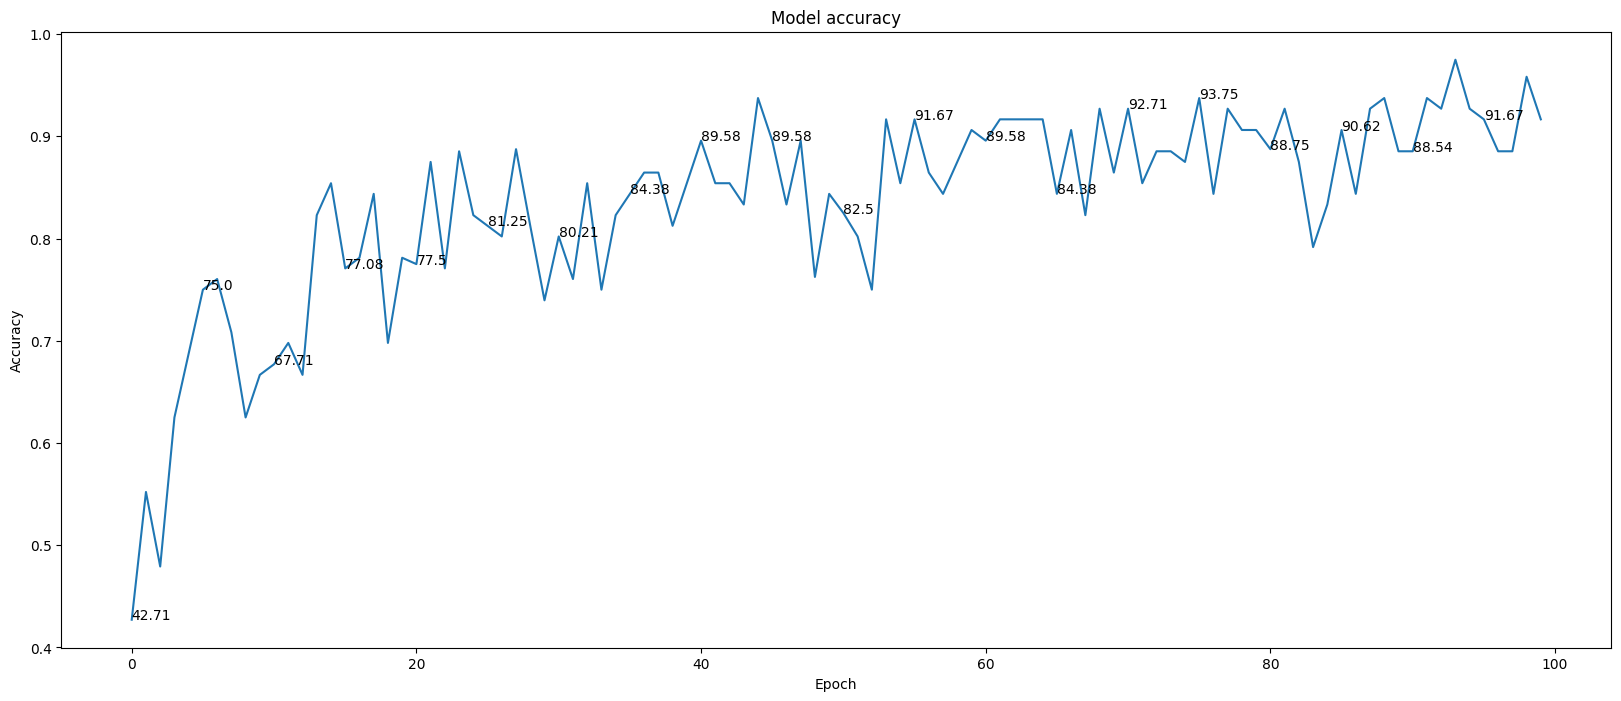

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

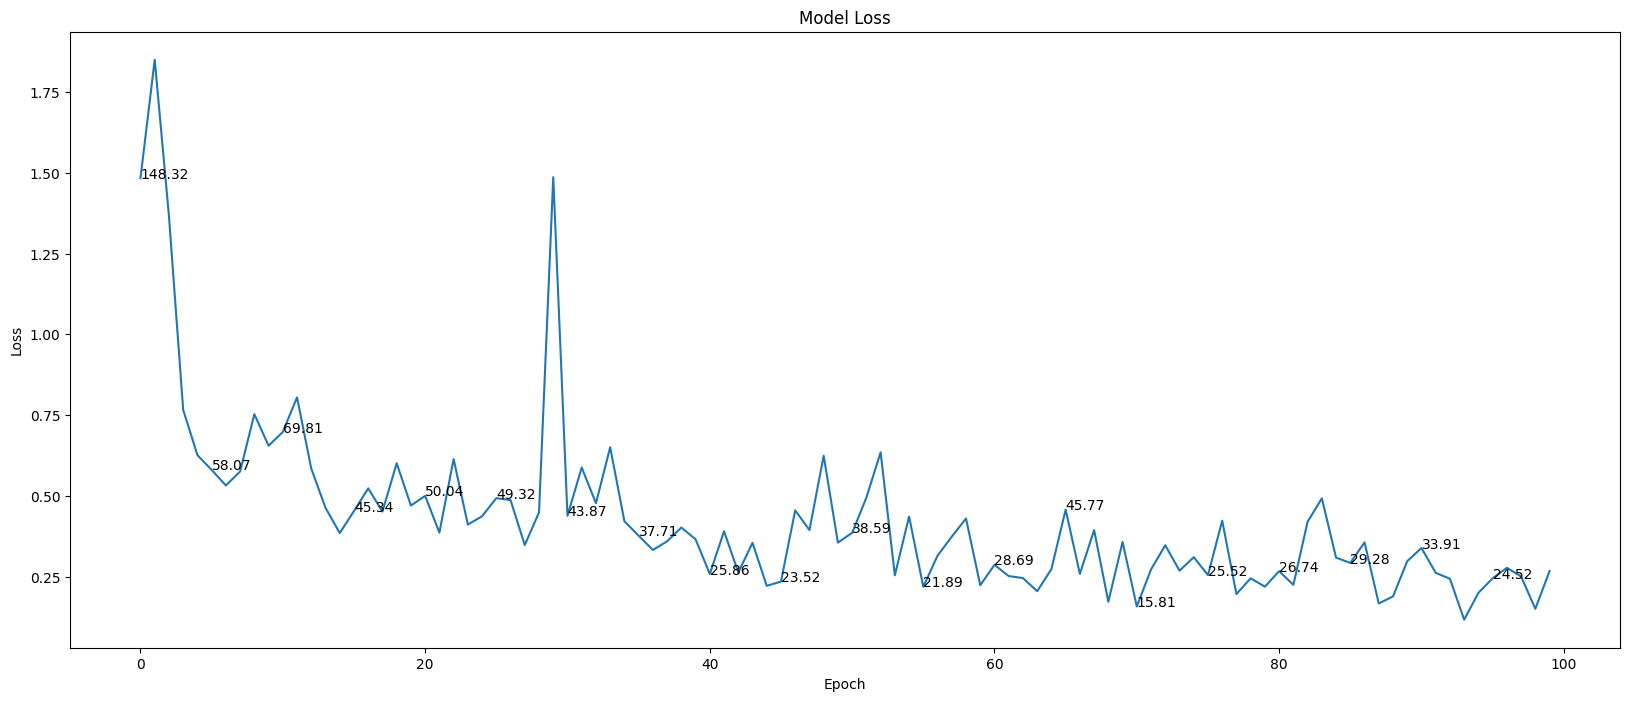

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()